In [ ]:
GPT-2 Small: d_model = 768
GPT-2 Medium: d_model = 1024
GPT-2 Large: d_model = 1280
GPT-2 XL: d_model = 1600

In [36]:
from tqdm.auto import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Config

def mask_diagonal(size_0, size_1):
    mask = torch.logical_not(torch.eye(size_0, size_1, dtype=bool))
    return mask

def get_percentile_5(model_name, load=True):
    
    # Load the GPT-2 model (small variant by default)
    if load:
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        config = GPT2Config.from_pretrained(model_name)
        # we need to init only embeddings
        config.n_layer = 1
        config.n_head = 1
        model = GPT2LMHeadModel(config)

    # Extract the language model head (unembedding layer)
    lm_head = model.lm_head  # This is the linear layer that maps hidden states back to vocabulary

    # Since GPT-2 uses tied embeddings, the lm_head weight matrix is the same as the input embeddings
    w_t = lm_head.weight.data  # This is the weight matrix [vocab_size, d_model]
    gamma = model.transformer.ln_f.weight.data
    h_t = model.transformer.ln_f(gamma*w_t).data

    # Output results
    print(f"Mean of w_t norms: {torch.norm(w_t, dim=1).mean()}")
    print(f"Variance of w_t norms: {torch.norm(w_t, dim=1).std()}")

    # Output results
    print(f"Mean of h_t norms: {torch.norm(h_t, dim=1).mean()}")
    print(f"Variance of h_t norms: {torch.norm(h_t, dim=1).std()}")


    h_t_w_t = (h_t * w_t).sum(axis=1)

    # Set the batch size
    batch_size = 1000
    vocab_size = w_t.size(0)
    num_batches = vocab_size // batch_size + (vocab_size % batch_size != 0)

    mean_sum = 0.0
    mean_sum_sq = 0.0
    var_sum = 0.0

    total_elements = 0

    percentile_5_all = []

    for i in tqdm(range(0, vocab_size, batch_size)):
        batch_end = min(i + batch_size, vocab_size)
        batch_w_t = w_t[i:batch_end]
        batch_h_t = h_t[i:batch_end]
        mask = mask_diagonal(batch_end-i, vocab_size)

        # 4. <h_t, w_i> for w_t != w_i (in batches)
        batch_h_t_w_i = torch.matmul(batch_h_t, w_t.T)

        # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
        h_t_w_t_minus_w_i = h_t_w_t[i:batch_end].unsqueeze(1) - batch_h_t_w_i
        percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 2500, dim=1).values

        percentile_5_all.append(percentile_5)
        mean_sum += percentile_5.sum().item()
        mean_sum_sq += (percentile_5 ** 2).sum().item()

        total_elements += percentile_5.size(0)

    mean = mean_sum / total_elements
    var = mean_sum_sq / total_elements - mean ** 2

    print(f"Mean of <h_t,  w_t - w_i> for w_t != w_i: {mean}")
    print(f"Variance of <h_t,  w_t - w_i> for w_t != w_i: {var}")
    return torch.hstack(percentile_5_all).numpy()

In [8]:
percentile_5_all = dict()
for model_name in ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']:
    print(model_name)
    percentile_5_all[model_name] = get_percentile_5(model_name)
    percentile_5_all[model_name+'_init'] = get_percentile_5(model_name, load=False)

gpt2
Mean of w_t norms: 3.9585366249084473
Variance of w_t norms: 0.43368640542030334
Mean of h_t norms: 325.51611328125
Variance of h_t norms: 7.914751052856445


100%|██████████| 51/51 [00:21<00:00,  2.42it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 42.87249986242588
Variance of <h_t,  w_t - w_i> for w_t != w_i: 163.3239856137459
Mean of w_t norms: 0.5540536046028137
Variance of w_t norms: 0.014063533395528793
Mean of h_t norms: 27.371450424194336
Variance of h_t norms: 0.017052920535206795


100%|██████████| 51/51 [00:18<00:00,  2.72it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 14.253639272654182
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.15505893760922618
gpt2-medium
Mean of w_t norms: 3.684203624725342
Variance of w_t norms: 0.40357089042663574
Mean of h_t norms: 340.6470031738281
Variance of h_t norms: 13.759939193725586


100%|██████████| 51/51 [00:26<00:00,  1.95it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 60.548586126683844
Variance of <h_t,  w_t - w_i> for w_t != w_i: 320.348631305465
Mean of w_t norms: 0.6398297548294067
Variance of w_t norms: 0.014081780798733234
Mean of h_t norms: 31.60621452331543
Variance of h_t norms: 0.017047300934791565


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 19.171470701143
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.20741460324262562
gpt2-large
Mean of w_t norms: 2.0462563037872314
Variance of w_t norms: 0.26776736974716187
Mean of h_t norms: 47.85879135131836
Variance of h_t norms: 0.346957802772522


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 78.99759027660326
Variance of <h_t,  w_t - w_i> for w_t != w_i: 104.54205627537976
Mean of w_t norms: 0.7153459191322327
Variance of w_t norms: 0.014144234359264374
Mean of h_t norms: 35.33701705932617
Variance of h_t norms: 0.017114825546741486


100%|██████████| 51/51 [00:53<00:00,  1.05s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 24.104097837505844
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.26156459307901514
gpt2-xl
Mean of w_t norms: 1.9148160219192505
Variance of w_t norms: 0.2344222068786621
Mean of h_t norms: 53.882057189941406
Variance of h_t norms: 0.28849589824676514


100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 85.96458344733072
Variance of <h_t,  w_t - w_i> for w_t != w_i: 111.58656987636459
Mean of w_t norms: 0.7998846769332886
Variance of w_t norms: 0.014107647351920605
Mean of h_t norms: 39.50830078125
Variance of h_t norms: 0.017059525474905968


100%|██████████| 51/51 [00:48<00:00,  1.05it/s]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 30.29035838796399
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.3253677186909272


In [98]:
from tqdm.auto import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Config

def get_percentile_5_for_w_i(model_name, load=True):
    
    # Load the GPT-2 model (small variant by default)
    if load:
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        config = GPT2Config.from_pretrained(model_name)
        # we need to init only embeddings
        config.n_layer = 1
        config.n_head = 1
        model = GPT2LMHeadModel(config)

    # Extract the language model head (unembedding layer)
    lm_head = model.lm_head  # This is the linear layer that maps hidden states back to vocabulary

    # Since GPT-2 uses tied embeddings, the lm_head weight matrix is the same as the input embeddings
    w_t = lm_head.weight.data  # This is the weight matrix [vocab_size, d_model]
    gamma = model.transformer.ln_f.weight.data
    h_t = model.transformer.ln_f(gamma*w_t).data
    
    

    # Output results
    print(f"Mean of w_t norms: {torch.norm(w_t, dim=1).mean()}")
    print(f"Variance of w_t norms: {torch.norm(w_t, dim=1).std()}")

    # Output results
    print(f"Mean of h_t norms: {torch.norm(h_t, dim=1).mean()}")
    print(f"Variance of h_t norms: {torch.norm(h_t, dim=1).std()}")


    h_t_w_t = (h_t * w_t).sum(axis=1)

    # Set the batch size
    batch_size = 1000
    vocab_size = w_t.size(0)
    num_batches = vocab_size // batch_size + (vocab_size % batch_size != 0)

    mean_sum = 0.0
    mean_sum_sq = 0.0
    var_sum = 0.0

    total_elements = 0

    percentile_5_all = []

    for i in tqdm(range(0, vocab_size, batch_size)):
        batch_end = min(i + batch_size, vocab_size)
        batch_w_t = w_t[i:batch_end]
        batch_h_t = h_t[i:batch_end]

        # 4. <h_t, w_i> for w_t != w_i (in batches)
        batch_h_t_w_i = torch.matmul(h_t, batch_w_t.T)

        # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
        h_t_w_t_minus_w_i = (h_t_w_t.unsqueeze(1) - batch_h_t_w_i).T
        percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 2500, dim=1).values

        percentile_5_all.append(percentile_5)
        mean_sum += percentile_5.sum().item()
        mean_sum_sq += (percentile_5 ** 2).sum().item()

        total_elements += percentile_5.size(0)

    mean = mean_sum / total_elements
    var = mean_sum_sq / total_elements - mean ** 2

    print(f"Mean of <h_t,  w_t - w_i> for w_t != w_i: {mean}")
    print(f"Variance of <h_t,  w_t - w_i> for w_t != w_i: {var}")
    return torch.hstack(percentile_5_all).numpy()

In [99]:
percentile_5_for_w_i = dict()
for model_name in ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']:
    print(model_name)
    percentile_5_for_w_i[model_name] = get_percentile_5_for_w_i(model_name)
    percentile_5_for_w_i[model_name+'_init'] = get_percentile_5_for_w_i(model_name, load=False)

gpt2
Mean of w_t norms: 3.9585366249084473
Variance of w_t norms: 0.43368640542030334
Mean of h_t norms: 325.51611328125
Variance of h_t norms: 7.914751052856445


100%|██████████| 51/51 [00:51<00:00,  1.02s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 32.96831704958389
Variance of <h_t,  w_t - w_i> for w_t != w_i: 29.14622820715067
Mean of w_t norms: 0.5540944337844849
Variance of w_t norms: 0.014196204952895641
Mean of h_t norms: 27.371490478515625
Variance of h_t norms: 0.01721799559891224


100%|██████████| 51/51 [00:54<00:00,  1.07s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 14.043113212540666
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0003872455544069453
gpt2-medium
Mean of w_t norms: 3.684203624725342
Variance of w_t norms: 0.40357089042663574
Mean of h_t norms: 340.6470031738281
Variance of h_t norms: 13.759939193725586


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 49.05501130439541
Variance of <h_t,  w_t - w_i> for w_t != w_i: 75.04945587330758
Mean of w_t norms: 0.6398733854293823
Variance of w_t norms: 0.014200717210769653
Mean of h_t norms: 31.606258392333984
Variance of h_t norms: 0.017201360315084457


100%|██████████| 51/51 [01:07<00:00,  1.33s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 18.92703964513028
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0004000642826440526
gpt2-large
Mean of w_t norms: 2.0462563037872314
Variance of w_t norms: 0.26776736974716187
Mean of h_t norms: 47.85879135131836
Variance of h_t norms: 0.346957802772522


100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 70.03631257212926
Variance of <h_t,  w_t - w_i> for w_t != w_i: 7.536630712622355
Mean of w_t norms: 0.7153952121734619
Variance of w_t norms: 0.01416912954300642
Mean of h_t norms: 35.33707809448242
Variance of h_t norms: 0.017140012234449387


100%|██████████| 51/51 [01:29<00:00,  1.76s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 23.83276395848775
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.00041574576300718036
gpt2-xl
Mean of w_t norms: 1.9148160219192505
Variance of w_t norms: 0.2344222068786621
Mean of h_t norms: 53.882057189941406
Variance of h_t norms: 0.28849589824676514


100%|██████████| 51/51 [01:29<00:00,  1.75s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 75.52464539299253
Variance of <h_t,  w_t - w_i> for w_t != w_i: 5.177514441175845
Mean of w_t norms: 0.7999414801597595
Variance of w_t norms: 0.01413149107247591
Mean of h_t norms: 39.50837326049805
Variance of h_t norms: 0.01708083041012287


100%|██████████| 51/51 [01:20<00:00,  1.57s/it]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 29.98783878792693
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.00042334841691626934


In [72]:
from tqdm.auto import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Config

def get_alpha_percentile_5_for_w_i(model_name, load=True):
    
    # Load the GPT-2 model (small variant by default)
    if load:
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        config = GPT2Config.from_pretrained(model_name)
        # we need to init only embeddings
        config.n_layer = 1
        config.n_head = 1
        model = GPT2LMHeadModel(config)

    # Extract the language model head (unembedding layer)
    lm_head = model.lm_head  # This is the linear layer that maps hidden states back to vocabulary

    # Since GPT-2 uses tied embeddings, the lm_head weight matrix is the same as the input embeddings
    w_t = lm_head.weight.data  # This is the weight matrix [vocab_size, d_model]
    gamma = model.transformer.ln_f.weight.data
    h_t = model.transformer.ln_f(gamma*w_t).data
    
    w_t_norm = torch.norm(w_t, dim=1)

    # Output results
    print(f"Mean of w_t norms: {torch.norm(w_t, dim=1).mean()}")
    print(f"Variance of w_t norms: {torch.norm(w_t, dim=1).std()}")

    # Output results
    print(f"Mean of h_t norms: {torch.norm(h_t, dim=1).mean()}")
    print(f"Variance of h_t norms: {torch.norm(h_t, dim=1).std()}")


    h_t_w_t = (h_t * w_t).sum(axis=1)

    # Set the batch size
    batch_size = 1000
    vocab_size = w_t.size(0)
    num_batches = vocab_size // batch_size + (vocab_size % batch_size != 0)

    mean_sum = 0.0
    mean_sum_sq = 0.0
    var_sum = 0.0

    total_elements = 0

    percentile_5_all = []

    for i in tqdm(range(0, vocab_size, batch_size)):
        batch_end = min(i + batch_size, vocab_size)
        batch_w_t = w_t[i:batch_end]
        batch_h_t = h_t[i:batch_end]

        # 4. <h_t, w_i> for w_t != w_i (in batches)
        batch_h_t_w_i = torch.matmul(h_t, batch_w_t.T)

        # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
        h_t_w_t_minus_w_i = ((h_t_w_t.unsqueeze(1) - batch_h_t_w_i)/w_t_norm.unsqueeze(1)).T
        percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 2500, dim=1).values

        percentile_5_all.append(percentile_5)
        mean_sum += percentile_5.sum().item()
        mean_sum_sq += (percentile_5 ** 2).sum().item()

        total_elements += percentile_5.size(0)

    mean = mean_sum / total_elements
    var = mean_sum_sq / total_elements - mean ** 2

    print(f"Mean of <h_t,  w_t - w_i> for w_t != w_i: {mean}")
    print(f"Variance of <h_t,  w_t - w_i> for w_t != w_i: {var}")
    return torch.hstack(percentile_5_all).numpy()

In [76]:
alpha_percentile_5_for_w_i = dict()
for model_name in ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']:
    print(model_name)
    alpha_percentile_5_for_w_i[model_name] = get_alpha_percentile_5_for_w_i(model_name)
    alpha_percentile_5_for_w_i[model_name+'_init'] = get_alpha_percentile_5_for_w_i(model_name, load=False)

gpt2
Mean of w_t norms: 3.9585366249084473
Variance of w_t norms: 0.43368640542030334
Mean of h_t norms: 325.51611328125
Variance of h_t norms: 7.914751052856445


100%|██████████| 51/51 [00:21<00:00,  2.33it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 9.643192574153227
Variance of <h_t,  w_t - w_i> for w_t != w_i: 2.303540560754641
Mean of w_t norms: 0.5541560649871826
Variance of w_t norms: 0.01412238273769617
Mean of h_t norms: 27.371570587158203
Variance of h_t norms: 0.017120838165283203


100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 25.72334875497754
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0018200499240492718
gpt2-medium
Mean of w_t norms: 3.684203624725342
Variance of w_t norms: 0.40357089042663574
Mean of h_t norms: 340.6470031738281
Variance of h_t norms: 13.759939193725586


100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 15.318474845932531
Variance of <h_t,  w_t - w_i> for w_t != w_i: 6.272935976560689
Mean of w_t norms: 0.6397901773452759
Variance of w_t norms: 0.014143177308142185
Mean of h_t norms: 31.60616683959961
Variance of h_t norms: 0.017128609120845795


100%|██████████| 51/51 [00:39<00:00,  1.29it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 29.960891991725035
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.001409675404374866
gpt2-large
Mean of w_t norms: 2.0462563037872314
Variance of w_t norms: 0.26776736974716187
Mean of h_t norms: 47.85879135131836
Variance of h_t norms: 0.346957802772522


100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 38.97666830382459
Variance of <h_t,  w_t - w_i> for w_t != w_i: 5.106785402246942
Mean of w_t norms: 0.7154437303543091
Variance of w_t norms: 0.014160022139549255
Mean of h_t norms: 35.337135314941406
Variance of h_t norms: 0.017134806141257286


100%|██████████| 51/51 [00:42<00:00,  1.21it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 33.693880777024845
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0011031401591026224
gpt2-xl
Mean of w_t norms: 1.9148160219192505
Variance of w_t norms: 0.2344222068786621
Mean of h_t norms: 53.882057189941406
Variance of h_t norms: 0.28849589824676514


100%|██████████| 51/51 [00:53<00:00,  1.05s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 45.18025835486848
Variance of <h_t,  w_t - w_i> for w_t != w_i: 4.983858425664266
Mean of w_t norms: 0.799998939037323
Variance of w_t norms: 0.01415017619729042
Mean of h_t norms: 39.50843811035156
Variance of h_t norms: 0.017101850360631943


100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 37.86703929692008
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0008693185245647328


In [77]:
from tqdm.auto import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Config

def get_betta_percentile_5_for_w_i(model_name, load=True):
    
    # Load the GPT-2 model (small variant by default)
    if load:
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        config = GPT2Config.from_pretrained(model_name)
        # we need to init only embeddings
        config.n_layer = 1
        config.n_head = 1
        model = GPT2LMHeadModel(config)

    # Extract the language model head (unembedding layer)
    lm_head = model.lm_head  # This is the linear layer that maps hidden states back to vocabulary

    # Since GPT-2 uses tied embeddings, the lm_head weight matrix is the same as the input embeddings
    w_t = lm_head.weight.data  # This is the weight matrix [vocab_size, d_model]
    gamma = model.transformer.ln_f.weight.data
    h_t = model.transformer.ln_f(gamma*w_t).data
    
    w_t_norm = torch.norm(w_t, dim=1)
    h_t_norm = torch.norm(h_t, dim=1)

    # Output results
    print(f"Mean of w_t norms: {torch.norm(w_t, dim=1).mean()}")
    print(f"Variance of w_t norms: {torch.norm(w_t, dim=1).std()}")

    # Output results
    print(f"Mean of h_t norms: {torch.norm(h_t, dim=1).mean()}")
    print(f"Variance of h_t norms: {torch.norm(h_t, dim=1).std()}")


    h_t_w_t = (h_t * w_t).sum(axis=1)

    # Set the batch size
    batch_size = 1000
    vocab_size = w_t.size(0)
    num_batches = vocab_size // batch_size + (vocab_size % batch_size != 0)

    mean_sum = 0.0
    mean_sum_sq = 0.0
    var_sum = 0.0

    total_elements = 0

    percentile_5_all = []

    for i in tqdm(range(0, vocab_size, batch_size)):
        batch_end = min(i + batch_size, vocab_size)
        batch_w_t = w_t[i:batch_end]
        batch_h_t = h_t[i:batch_end]

        # 4. <h_t, w_i> for w_t != w_i (in batches)
        batch_h_t_w_i = torch.matmul(h_t, batch_w_t.T)

        # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
        h_t_w_t_minus_w_i = ((h_t_w_t.unsqueeze(1) - batch_h_t_w_i)/h_t_norm.unsqueeze(1)).T
        percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 2500, dim=1).values

        percentile_5_all.append(percentile_5)
        mean_sum += percentile_5.sum().item()
        mean_sum_sq += (percentile_5 ** 2).sum().item()

        total_elements += percentile_5.size(0)

    mean = mean_sum / total_elements
    var = mean_sum_sq / total_elements - mean ** 2

    print(f"Mean of <h_t,  w_t - w_i> for w_t != w_i: {mean}")
    print(f"Variance of <h_t,  w_t - w_i> for w_t != w_i: {var}")
    return torch.hstack(percentile_5_all).numpy()

In [78]:
betta_percentile_5_for_w_i = dict()
for model_name in ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']:
    print(model_name)
    betta_percentile_5_for_w_i[model_name] = get_betta_percentile_5_for_w_i(model_name)
    print(model_name+'_init')
    betta_percentile_5_for_w_i[model_name+'_init'] = get_betta_percentile_5_for_w_i(model_name, load=False)

gpt2
Mean of w_t norms: 3.9585366249084473
Variance of w_t norms: 0.43368640542030334
Mean of h_t norms: 325.51611328125
Variance of h_t norms: 7.914751052856445


100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.09784106284882228
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.00025721918388830686
gpt2_init
Mean of w_t norms: 0.5540703535079956
Variance of w_t norms: 0.014130977913737297
Mean of h_t norms: 27.3714656829834
Variance of h_t norms: 0.01714562624692917


100%|██████████| 51/51 [00:22<00:00,  2.30it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.5133833652642604
Variance of <h_t,  w_t - w_i> for w_t != w_i: 5.188595362248805e-07
gpt2-medium
Mean of w_t norms: 3.684203624725342
Variance of w_t norms: 0.40357089042663574
Mean of h_t norms: 340.6470031738281
Variance of h_t norms: 13.759939193725586


100%|██████████| 51/51 [00:30<00:00,  1.65it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.13647489818895817
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.00058443337789316
gpt2-medium_init
Mean of w_t norms: 0.6398448944091797
Variance of w_t norms: 0.01418913621455431
Mean of h_t norms: 31.606229782104492
Variance of h_t norms: 0.017183048650622368


100%|██████████| 51/51 [00:32<00:00,  1.55it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.599160355749475
Variance of <h_t,  w_t - w_i> for w_t != w_i: 3.895667592401786e-07
gpt2-large
Mean of w_t norms: 2.0462563037872314
Variance of w_t norms: 0.26776736974716187
Mean of h_t norms: 47.85879135131836
Variance of h_t norms: 0.346957802772522


100%|██████████| 51/51 [00:39<00:00,  1.30it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 1.456308156398378
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0031278617221301985
gpt2-large_init
Mean of w_t norms: 0.7153488993644714
Variance of w_t norms: 0.014198420569300652
Mean of h_t norms: 35.33702087402344
Variance of h_t norms: 0.01717432402074337


100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.6746977599955565
Variance of <h_t,  w_t - w_i> for w_t != w_i: 3.4355849931611004e-07
gpt2-xl
Mean of w_t norms: 1.9148160219192505
Variance of w_t norms: 0.2344222068786621
Mean of h_t norms: 53.882057189941406
Variance of h_t norms: 0.28849589824676514


100%|██████████| 51/51 [00:47<00:00,  1.08it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 1.3963667969779863
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0016803975754502432
gpt2-xl_init
Mean of w_t norms: 0.7997192740440369
Variance of w_t norms: 0.014075861312448978
Mean of h_t norms: 39.50810623168945
Variance of h_t norms: 0.01702141761779785


100%|██████████| 51/51 [00:52<00:00,  1.04s/it]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.7592071913329355
Variance of <h_t,  w_t - w_i> for w_t != w_i: 2.8345229519111115e-07


In [87]:
from tqdm.auto import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Config

def get_gamma_percentile_5_for_w_i(model_name, load=True):
    
    # Load the GPT-2 model (small variant by default)
    if load:
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        config = GPT2Config.from_pretrained(model_name)
        # we need to init only embeddings
        config.n_layer = 1
        config.n_head = 1
        model = GPT2LMHeadModel(config)

    # Extract the language model head (unembedding layer)
    lm_head = model.lm_head  # This is the linear layer that maps hidden states back to vocabulary

    # Since GPT-2 uses tied embeddings, the lm_head weight matrix is the same as the input embeddings
    w_t = lm_head.weight.data  # This is the weight matrix [vocab_size, d_model]
    gamma = model.transformer.ln_f.weight.data
    h_t = model.transformer.ln_f(gamma*w_t).data
    
    w_t_norm = torch.norm(w_t, dim=1)
    h_t_norm = torch.norm(h_t, dim=1)

    # Output results
    print(f"Mean of w_t norms: {torch.norm(w_t, dim=1).mean()}")
    print(f"Variance of w_t norms: {torch.norm(w_t, dim=1).std()}")

    # Output results
    print(f"Mean of h_t norms: {torch.norm(h_t, dim=1).mean()}")
    print(f"Variance of h_t norms: {torch.norm(h_t, dim=1).std()}")


    h_t_w_t = (h_t * w_t).sum(axis=1)

    # Set the batch size
    batch_size = 1000
    vocab_size = w_t.size(0)
    num_batches = vocab_size // batch_size + (vocab_size % batch_size != 0)

    mean_sum = 0.0
    mean_sum_sq = 0.0
    var_sum = 0.0

    total_elements = 0

    percentile_5_all = []

    for i in tqdm(range(0, vocab_size, batch_size)):
        batch_end = min(i + batch_size, vocab_size)
        batch_w_t = w_t[i:batch_end]
        batch_h_t = h_t[i:batch_end]

        # 4. <h_t, w_i> for w_t != w_i (in batches)
        batch_h_t_w_i = torch.matmul(h_t, batch_w_t.T)

        # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
        h_t_w_t_minus_w_i = ((h_t_w_t.unsqueeze(1) - batch_h_t_w_i)/(h_t_norm * w_t_norm).unsqueeze(1)).T
        percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 2500, dim=1).values

        percentile_5_all.append(percentile_5)
        mean_sum += percentile_5.sum().item()
        mean_sum_sq += (percentile_5 ** 2).sum().item()

        total_elements += percentile_5.size(0)

    mean = mean_sum / total_elements
    var = mean_sum_sq / total_elements - mean ** 2

    print(f"Mean of <h_t,  w_t - w_i> for w_t != w_i: {mean}")
    print(f"Variance of <h_t,  w_t - w_i> for w_t != w_i: {var}")
    return torch.hstack(percentile_5_all).numpy()

In [88]:
gamma_percentile_5_for_w_i = dict()
for model_name in ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']:
    print(model_name)
    gamma_percentile_5_for_w_i[model_name] = get_gamma_percentile_5_for_w_i(model_name)
    print(model_name+'_init')
    gamma_percentile_5_for_w_i[model_name+'_init'] = get_gamma_percentile_5_for_w_i(model_name, load=False)

gpt2
Mean of w_t norms: 3.9585366249084473
Variance of w_t norms: 0.43368640542030334
Mean of h_t norms: 325.51611328125
Variance of h_t norms: 7.914751052856445


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.028726815612833655
Variance of <h_t,  w_t - w_i> for w_t != w_i: 2.061642933913249e-05
gpt2_init
Mean of w_t norms: 0.5540507435798645
Variance of w_t norms: 0.014170287176966667
Mean of h_t norms: 27.371440887451172
Variance of h_t norms: 0.01720152050256729


100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9398210911369661
Variance of <h_t,  w_t - w_i> for w_t != w_i: 2.455106286936015e-06
gpt2-medium
Mean of w_t norms: 3.684203624725342
Variance of w_t norms: 0.40357089042663574
Mean of h_t norms: 340.6470031738281
Variance of h_t norms: 13.759939193725586


100%|██████████| 51/51 [00:39<00:00,  1.29it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.04290915405569766
Variance of <h_t,  w_t - w_i> for w_t != w_i: 5.0639477769683734e-05
gpt2-medium_init
Mean of w_t norms: 0.6397746801376343
Variance of w_t norms: 0.014208591543138027
Mean of h_t norms: 31.60614013671875
Variance of h_t norms: 0.017211029306054115


100%|██████████| 51/51 [00:40<00:00,  1.27it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9479728131121854
Variance of <h_t,  w_t - w_i> for w_t != w_i: 1.4017910671126899e-06
gpt2-large
Mean of w_t norms: 2.0462563037872314
Variance of w_t norms: 0.26776736974716187
Mean of h_t norms: 47.85879135131836
Variance of h_t norms: 0.346957802772522


100%|██████████| 51/51 [00:42<00:00,  1.21it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.8157517272838702
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.0021997499289629907
gpt2-large_init
Mean of w_t norms: 0.715506374835968
Variance of w_t norms: 0.014120807871222496
Mean of h_t norms: 35.33721160888672
Variance of h_t norms: 0.017068281769752502


100%|██████████| 51/51 [00:46<00:00,  1.10it/s]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9535162106129961
Variance of <h_t,  w_t - w_i> for w_t != w_i: 8.976526046922118e-07
gpt2-xl
Mean of w_t norms: 1.9148160219192505
Variance of w_t norms: 0.2344222068786621
Mean of h_t norms: 53.882057189941406
Variance of h_t norms: 0.28849589824676514


100%|██████████| 51/51 [00:53<00:00,  1.05s/it]


Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.8398551446784233
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.001678654400853019
gpt2-xl_init
Mean of w_t norms: 0.799909770488739
Variance of w_t norms: 0.014127794653177261
Mean of h_t norms: 39.50833511352539
Variance of h_t norms: 0.017071105539798737


100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9584696889433624
Variance of <h_t,  w_t - w_i> for w_t != w_i: 5.934279190267233e-07


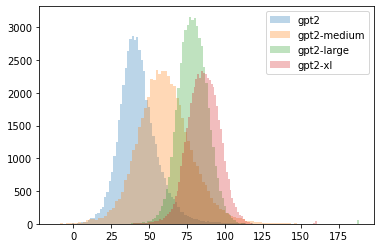

In [27]:
import matplotlib.pyplot as plt

for model_name in percentile_5_all:
    if 'init' in model_name:
        continue
    plt.hist(percentile_5_all[model_name], bins=100, label=model_name, alpha=0.3)
#     plt.hist(percentile_5_all[model_name+'_init'], bins=100, label=model_name, alpha=0.3)

plt.legend()
plt.show()

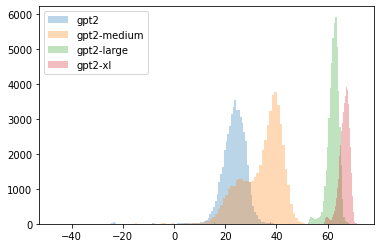

In [67]:
import matplotlib.pyplot as plt

for model_name in percentile_5_for_w_i:
    if 'init' in model_name:
        continue
    plt.hist(percentile_5_for_w_i[model_name], bins=100, label=model_name, alpha=0.3)
#     plt.hist(percentile_5_all[model_name+'_init'], bins=100, label=model_name, alpha=0.3)

plt.legend()
plt.show()

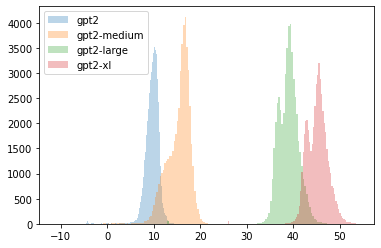

In [74]:
import matplotlib.pyplot as plt

for model_name in alpha_percentile_5_for_w_i:
    if 'init' in model_name:
        continue
    plt.hist(alpha_percentile_5_for_w_i[model_name], bins=100, label=model_name, alpha=0.3)
#     plt.hist(percentile_5_all[model_name+'_init'], bins=100, label=model_name, alpha=0.3)

plt.legend()
plt.show()

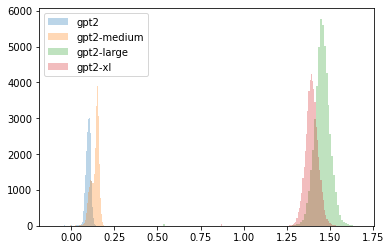

In [86]:
import matplotlib.pyplot as plt

for model_name in betta_percentile_5_for_w_i:
    if 'init' in model_name:
        continue
    plt.hist(betta_percentile_5_for_w_i[model_name], bins=100, label=model_name, alpha=0.3)
#     plt.hist(betta_percentile_5_for_w_i[model_name+'_init'], bins=100, label=model_name, alpha=0.3)

plt.legend()
plt.show()

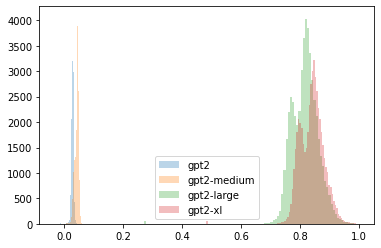

In [116]:
import matplotlib.pyplot as plt

for model_name in [
    'gpt2', 'gpt2-medium', 
    'gpt2-large', 'gpt2-xl'
]:
    if 'init' in model_name:
        continue
    plt.hist(gamma_percentile_5_for_w_i[model_name], bins=100, label=model_name, alpha=0.3)
#     plt.hist(betta_percentile_5_for_w_i[model_name+'_init'], bins=100, label=model_name, alpha=0.3)

plt.legend()
plt.show()

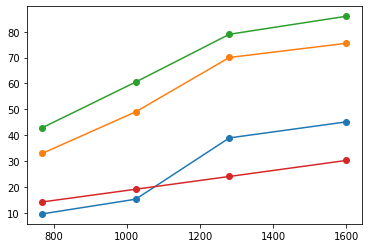

In [75]:
x = [768, 1024, 1280, 1600]
y = [14.25, 19.17, 24.10, 30.29]
y2 = [42.87, 60.55, 79.00, 85.96]
y3 = [32.97, 49.05, 70.04, 75.52]
y4 = [9.64, 15.32, 38.98, 45.18]

plt.scatter(x, y4)
plt.plot(x, y4)
plt.scatter(x, y3)
plt.plot(x, y3)
plt.scatter(x, y2)
plt.plot(x, y2)
plt.scatter(x, y)
plt.plot(x, y)

In [26]:
for xx, yy in zip(x, y):
    print(yy/xx)

0.0185546875
0.018720703125
0.018828125
0.01893125


In [164]:
from nanoGPT.model import GPTConfig, GPT
# init from a model saved in a specific directory

def get_percentile_5(ckpt_path, load=True):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    gptconf = GPTConfig(**checkpoint['model_args'])
    weight_tying = True
    model = GPT(gptconf, weight_tying=weight_tying)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if load:
        model.load_state_dict(state_dict)
    # Extract the language model head (unembedding layer)
    lm_head = model.lm_head  # This is the linear layer that maps hidden states back to vocabulary

    # Since GPT-2 uses tied embeddings, the lm_head weight matrix is the same as the input embeddings
    w_t = lm_head.weight.data  # This is the weight matrix [vocab_size, d_model]
    gamma = model.transformer.ln_f.weight.data
    h_t = model.transformer.ln_f(gamma*w_t).data
    
    w_t_norm = torch.norm(w_t, dim=1)
    h_t_norm = torch.norm(h_t, dim=1)

    # Output results
    print(f"Mean of w_t norms: {torch.norm(w_t, dim=1).mean()}")
    print(f"Variance of w_t norms: {torch.norm(w_t, dim=1).std()}")

    # Output results
    print(f"Mean of h_t norms: {torch.norm(h_t, dim=1).mean()}")
    print(f"Variance of h_t norms: {torch.norm(h_t, dim=1).std()}")


    h_t_w_t = (h_t * w_t).sum(axis=1)

    # Set the batch size
    batch_size = 1000
    vocab_size = w_t.size(0)
    num_batches = vocab_size // batch_size + (vocab_size % batch_size != 0)

    mean_sum = 0.0
    mean_sum_sq = 0.0
    var_sum = 0.0

    total_elements = 0

    percentile_5_all = []

    for i in tqdm(range(0, vocab_size, batch_size)):
        batch_end = min(i + batch_size, vocab_size)
        batch_w_t = w_t[i:batch_end]
        batch_h_t = h_t[i:batch_end]

#         # 4. <h_t, w_i> for w_t != w_i (in batches)
#         batch_h_t_w_i = torch.matmul(batch_h_t, w_t.T)

#         # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
#         h_t_w_t_minus_w_i = h_t_w_t[i:batch_end].unsqueeze(1) - batch_h_t_w_i
#         percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 7, dim=1).values
        
        # 4. <h_t, w_i> for w_t != w_i (in batches)
        batch_h_t_w_i = torch.matmul(h_t, batch_w_t.T)

        # 5. <h_t, w_t - w_i> for w_t != w_i (in batches)
#         h_t_w_t_minus_w_i = (h_t_w_t.unsqueeze(1) - batch_h_t_w_i).T
        h_t_w_t_minus_w_i = ((h_t_w_t.unsqueeze(1) - batch_h_t_w_i)/(h_t_norm * w_t_norm).unsqueeze(1)).T
        percentile_5 = torch.kthvalue(h_t_w_t_minus_w_i, 65, dim=1).values

        percentile_5_all.append(percentile_5)
        mean_sum += percentile_5.sum().item()
        mean_sum_sq += (percentile_5 ** 2).sum().item()

        total_elements += percentile_5.size(0)

    mean = mean_sum / total_elements
    var = mean_sum_sq / total_elements - mean ** 2

    print(f"Mean of <h_t,  w_t - w_i> for w_t != w_i: {mean}")
    print(f"Variance of <h_t,  w_t - w_i> for w_t != w_i: {var}")
    return torch.hstack(percentile_5_all).numpy(), batch_h_t_w_i, w_t

In [165]:
percentile_5_all = dict()
batch_h_t_w_i = dict()
w_t = dict()

for ckpt_path in [
    'nanoGPT/out/proposed_margin_by_weight_type_3_alpha_0.0625_SE/ckpt.pt',
    'nanoGPT/out/proposed_margin_1.0_separated_embeddings/ckpt.pt',
    'nanoGPT/out/proposed_margin_1/ckpt.pt',
    'nanoGPT/out/baseline/ckpt.pt'
]:
    print(ckpt_path)
    percentile_5_all[ckpt_path], batch_h_t_w_i[ckpt_path], w_t[ckpt_path] = get_percentile_5(ckpt_path)

nanoGPT/out/proposed_margin_by_weight_type_3_alpha_0.0625_SE/ckpt.pt
number of parameters: 0.80M


/tmp/ipykernel_292/2556486887.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Mean of w_t norms: 0.5574177503585815
Variance of w_t norms: 0.06936384737491608
Mean of h_t norms: 9.458022117614746
Variance of h_t norms: 0.10536954551935196


100%|██████████| 1/1 [00:00<00:00, 99.05it/s]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9570445720966045
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.001996113984820136
nanoGPT/out/proposed_margin_1.0_separated_embeddings/ckpt.pt
number of parameters: 0.80M


Mean of w_t norms: 0.6109256744384766
Variance of w_t norms: 0.07702957838773727
Mean of h_t norms: 11.347818374633789
Variance of h_t norms: 0.11545183509588242


100%|██████████| 1/1 [00:00<00:00, 89.29it/s]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9183500436636117
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.005491605130566568
nanoGPT/out/proposed_margin_1/ckpt.pt
number of parameters: 0.80M


Mean of w_t norms: 0.6107277274131775
Variance of w_t norms: 0.08878485858440399
Mean of h_t norms: 11.244767189025879
Variance of h_t norms: 0.10734023153781891


100%|██████████| 1/1 [00:00<00:00, 53.06it/s]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9083449143629808
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.006660474333360922
nanoGPT/out/baseline/ckpt.pt
number of parameters: 0.80M


Mean of w_t norms: 0.9278639554977417
Variance of w_t norms: 0.3647285997867584
Mean of h_t norms: 17.92854881286621
Variance of h_t norms: 0.17443130910396576


100%|██████████| 1/1 [00:00<00:00, 45.83it/s]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.8245567908653846
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.03057198468044664


In [166]:
percentile_5_all['init'], batch_h_t_w_i['init'], w_t['init'] = get_percentile_5(ckpt_path, load=False)

/tmp/ipykernel_292/2556486887.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


number of parameters: 0.80M
Mean of w_t norms: 0.22540198266506195
Variance of w_t norms: 0.013307780027389526
Mean of h_t norms: 11.171341896057129
Variance of h_t norms: 0.01643950678408146


100%|██████████| 1/1 [00:00<00:00, 77.66it/s]

Mean of <h_t,  w_t - w_i> for w_t != w_i: 0.9934810931865986
Variance of <h_t,  w_t - w_i> for w_t != w_i: 0.00011619526020811843


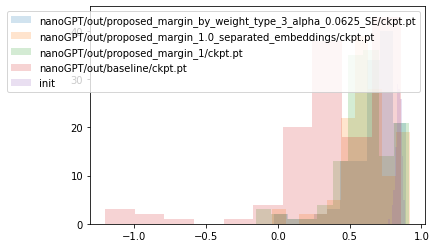

In [103]:
for model_name in percentile_5_all:
    plt.hist(percentile_5_all[model_name], label=model_name, alpha=0.2)
plt.legend()
plt.show()

In [105]:
def update_x(x):
    if x == ' ':
        return '\\s'
    elif x == '\n':
        return '\\n'
    return x

def get_token(i_s):
    result = []
    for i in i_s:
        if i < 65:
            result.append('b'+update_x(decode([i])))
        else:
            result.append('s'+update_x(decode([i-65])))
    return result

In [106]:
import numpy as np
import os
import pickle
from collections import Counter

meta_path = 'nanoGPT/data/shakespeare_char/meta.pkl'
load_meta = os.path.exists(meta_path)
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data_dir = 'nanoGPT/data/shakespeare_char'
data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')

counter = Counter(data)
counts = np.array(sorted(counter.values(), reverse=True))

sorted_tokens = np.array([token for token, _ in counter.most_common()])


In [107]:
sorted_tokens = np.hstack([sorted_tokens, sorted_tokens + 65])

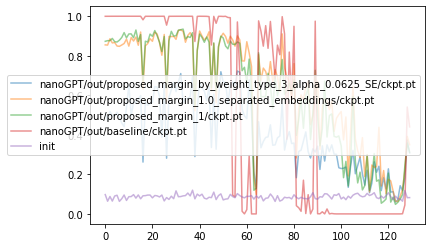

In [108]:
import torch.nn.functional as F

for model_name in batch_h_t_w_i:
    plt.plot(F.softmax(batch_h_t_w_i[model_name], dim=1).diag()[sorted_tokens], label=model_name, alpha=0.5)
plt.legend()
plt.show()